In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import os
from transformers import DataCollatorForSeq2Seq
import random

2025-05-16 11:51:19.186125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 11:51:19.186182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 11:51:19.251684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 11:51:19.386570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 11:51:20.850566: W tensorflow/compiler/tf2

In [3]:
with open('words_250000_train.txt', 'r') as f:
    words = f.read().splitlines()
data = np.random.permutation(words)

In [4]:
print(len(words))

227300


In [3]:
# data=data[:500]
split_index= int(0.95 * len(data))

# random.shuffle(data)
train_words = data[:split_index]
val_words = data[split_index:]

In [6]:
print(len(set(words)))

227300


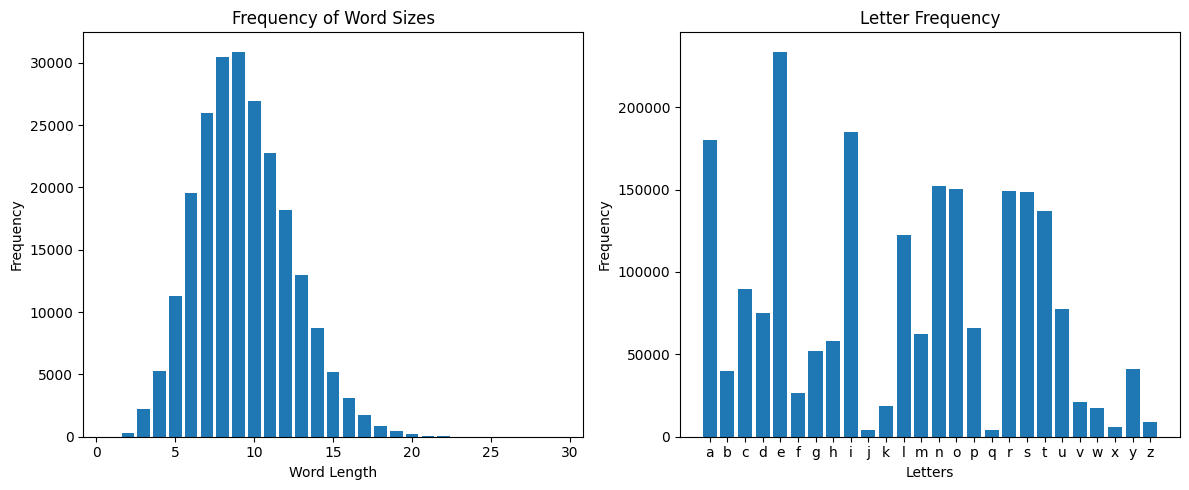

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

with open("words_250000_train.txt", "r") as f:
    words = f.read().split()



# Word size frequency
size_counts = Counter(len(word) for word in words)

# Letter frequency
letter_counts = Counter("".join(words).lower())
letter_counts = {k: v for k, v in sorted(letter_counts.items()) if k.isalpha()}

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Word size plot
axs[0].bar(size_counts.keys(), size_counts.values())
axs[0].set_xlabel("Word Length")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Frequency of Word Sizes")

# Letter frequency plot
axs[1].bar(letter_counts.keys(), letter_counts.values())
axs[1].set_xlabel("Letters")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Letter Frequency")

plt.tight_layout()
plt.show()

In [5]:
def simulate_game(word, correct_rate=0.4, max_wrong_guesses=6):
    word_idxs = {}
    all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    for i, c in enumerate(word):
        if c not in word_idxs:
            word_idxs[c] = []
        word_idxs[c].append(i)
    guesses = {}
    encoded_word = "*" * len(word)
    num_guesses = 0
    states, outputs = [], []
    while encoded_word != word and num_guesses < max_wrong_guesses:
        output = np.zeros(26)
        for ch in word_idxs:
            if ch not in guesses:
                output[ord(ch) - ord('a')] = len(word_idxs[ch])
        out_sum = np.sum(output)
        if out_sum > 0:
            output = output / out_sum
        else:
            raise ValueError("Invalid output distribution")
        outputs.append(output)
        states.append(''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN))
        correct_guess = np.random.random() < correct_rate
        if correct_guess:
            guess = np.random.choice(list(word_idxs.keys()))
            while guess in guesses:
                guess = np.random.choice(list(word_idxs.keys()))
        else:
            guess = np.random.choice(all_letters)
            while guess in guesses:
                guess = np.random.choice(all_letters)
        if guess in word_idxs:
            for i in word_idxs[guess]:
                encoded_word = encoded_word[:i] + guess + encoded_word[i + 1:]
        else:
            num_guesses += 1
        guesses[guess] = True
    return states, np.array(outputs), int(encoded_word == word)

def encode_game_states(word_list):
    all_states, all_outputs = [], []
    for word in word_list:
        states, outputs, _ = simulate_game(word)
        all_states.extend(states)
        all_outputs.extend(outputs)
    return all_states, np.array(all_outputs), None

In [4]:
#Freq Count of these letters individual
from collections import defaultdict
d=defaultdict(int)
for x in data:
    for y in x:
        d[y]+=1
print(d)  

defaultdict(<class 'int'>, {'p': 65785, 'e': 233745, 'r': 149228, 'i': 184746, 'w': 17732, 'g': 51850, 'c': 89367, 'o': 150052, 'n': 152259, 'a': 179837, 'l': 122431, 'u': 77304, 'd': 74856, 'm': 62191, 't': 137277, 'z': 8749, 'x': 6050, 's': 148462, 'k': 18685, 'b': 39840, 'f': 26431, 'y': 40985, 'q': 3986, 'v': 21057, 'h': 58051, 'j': 3790})


In [5]:
inv_ratios = {k: 1/v for k, v in d.items()}
total = sum(inv_ratios.values())
normalized = {k: round(v/total, 6) for k, v in inv_ratios.items()}

In [37]:
import numpy as np

log_inv = {k: 1 / np.log(v + 1) for k, v in d.items()}
total = sum(log_inv.values())
normalized = {k: round(v / total, 6) for k, v in log_inv.items()}

In [6]:
print(inv_ratios)

{'p': 1.520103367028958e-05, 'e': 4.278166377890436e-06, 'r': 6.701155279170129e-06, 'i': 5.4128370844294325e-06, 'w': 5.6395217685540266e-05, 'g': 1.9286403085824492e-05, 'c': 1.1189812794431949e-05, 'o': 6.664356356463093e-06, 'n': 6.567756257429774e-06, 'a': 5.5605909796093125e-06, 'l': 8.167865981654973e-06, 'u': 1.29359412190831e-05, 'd': 1.3358982579886716e-05, 'm': 1.60794970333328e-05, 't': 7.284541474536886e-06, 'z': 0.00011429877700308607, 'x': 0.00016528925619834712, 's': 6.735730355242419e-06, 'k': 5.3518865400053516e-05, 'b': 2.5100401606425704e-05, 'f': 3.78343611668117e-05, 'y': 2.439917042820544e-05, 'q': 0.0002508780732563974, 'v': 4.749014579474759e-05, 'h': 1.7226232106251398e-05, 'j': 0.0002638522427440633}


In [7]:
print(normalized)

{'p': 0.01265, 'e': 0.00356, 'r': 0.005576, 'i': 0.004504, 'w': 0.046929, 'g': 0.016049, 'c': 0.009312, 'o': 0.005546, 'n': 0.005465, 'a': 0.004627, 'l': 0.006797, 'u': 0.010765, 'd': 0.011117, 'm': 0.013381, 't': 0.006062, 'z': 0.095114, 'x': 0.137545, 's': 0.005605, 'k': 0.044536, 'b': 0.020887, 'f': 0.031484, 'y': 0.020304, 'q': 0.208768, 'v': 0.039519, 'h': 0.014335, 'j': 0.219564}


In [16]:

# log_inv = {k: 1 / np.log(v + 1) for k, v in d.items()}
min_val, max_val = min(normalized.values()), max(normalized.values())

scaled_weights = {
    k: round(0.37 + (v - min_val) / (max_val - min_val) * 0.2, 6)
    for k, v in normalized.items()
}

In [17]:
scaled_weights

{'p': 0.378417,
 'e': 0.37,
 'r': 0.371867,
 'i': 0.370874,
 'w': 0.410156,
 'g': 0.381564,
 'c': 0.375326,
 'o': 0.371839,
 'n': 0.371764,
 'a': 0.370988,
 'l': 0.372997,
 'u': 0.376671,
 'd': 0.376997,
 'm': 0.379093,
 't': 0.372317,
 'z': 0.454771,
 'x': 0.494058,
 's': 0.371893,
 'k': 0.40794,
 'b': 0.386043,
 'f': 0.395855,
 'y': 0.385503,
 'q': 0.560004,
 'v': 0.403295,
 'h': 0.379977,
 'j': 0.57}

In [12]:
sum(scaled_weights.values())/26

0.36231573076923074

In [13]:
hi={'h': 0.301549,
 'y': 0.331091,
 'd': 0.281124,
 'r': 0.23012,
 'o': 0.229734,
 'l': 0.244131,
 's': 0.230482,
 'a': 0.217315,
 't': 0.23598,
 'e': 0.2,
 'p': 0.291397,
 'i': 0.215506,
 'n': 0.228721,
 'g': 0.31093,
 'x': 0.535588,
 'c': 0.26745,
 'u': 0.278616,
 'm': 0.295931,
 'w': 0.410792,
 'f': 0.371194,
 'b': 0.333574,
 'v': 0.393356,
 'k': 0.405414,
 'q': 0.592693,
 'z': 0.489456,
 'j': 0.6}

In [44]:
from collections import defaultdict
import numpy as np

# words = ["apple", "banana", "cherry", "date"]

front_freq = defaultdict(int)
back_freq = defaultdict(int)
total_front = defaultdict(int)
total_back = defaultdict(int)

for word in words:
    L = len(word)
    for i, c in enumerate(word):
        front_freq[(c, i)] += 1
        total_front[i] += 1
        back_freq[(c, L - i - 1)] += 1
        total_back[L - i - 1] += 1

def word_score(word):
    score = 0
    L = len(word)
    for i, c in enumerate(word):
        f_pos = i
        b_pos = L - i - 1
        f_weight = 1 / (front_freq[(c, f_pos)] / total_front[f_pos])
        b_weight = 1 / (back_freq[(c, b_pos)] / total_back[b_pos])
        score += (f_weight + b_weight) / 2
    return score / L

scores = {word: word_score(word) for word in words}
print(scores)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [17]:
with open('words_250000_train.txt', 'r') as f:
    words = f.read().splitlines()
# data = np.random.permutation(words)

In [18]:
new=[x for x in words if len(x)>3]

In [46]:
new.sort(key=lambda x: scores[x])

In [ ]:
new[-2000:-4000:-1]


In [28]:
len(new)

227019

In [19]:
with open('final.txt', 'w') as f:
    for word in new:
        f.write(word + '\n')

In [42]:
rng = np.random.default_rng(42)
rf = rng.permutation(new[-2000:-40000:-1])
with open('train_rf.txt', 'w') as f:
    for word in rf[:30000]:
        f.write(word + '\n')
with open('val_rf.txt', 'w') as f:
    for word in rf[30000:]:
        f.write(word + '\n')

In [51]:
rng = np.random.default_rng(43)
mug = rng.permutation(new[:-150000:-1])
with open('train_mug.txt', 'w') as f:
    for word in mug[:145000]:
        f.write(word + '\n')
with open('val_mug.txt', 'w') as f:
    for word in mug[145000:]:
        f.write(word + '\n')

In [10]:
with open('words_250000_train.txt', 'r') as f:
    words1 = f.read().splitlines()
# data = np.random.permutation(words)

In [11]:
with open('words_corpus.txt', 'r') as f:
    words2 = f.read().splitlines()
# data = np.random.permutation(words)

In [12]:
ls

 9epoch/                                  hangman_api_user.ipynb
 Byt5-training.ipynb                      hangman_data_generation.py
 CanineHangmanPlayer.py                   hangman_data_generation3.py
 Data_analysis.ipynb                      hangman_training_data.parquet
 Hangman_analysis.ipynb                   hangman_word_split.py
 Hangman_transformers.pdf                 logs/
'Hybrid Inference.ipynb'                  lstm_model.h5
 Inference.ipynb                          lstm_model3.h5
 README.md                                lstm_model4.h5
 Self_play_finetune.ipynb                 lstm_model5.h5
'Training_Hangman (1).ipynb'              lstm_model6.h5
 Training_Hangman.ipynb                   o1/
 Untitled.ipynb                           self-play-accuracy.png
 __pycache__/                             self-play-loss.png
 byt5-checkpoint-epoch-try1/              t5-pretrained-hangman-log/
 byt5-checkpoint-epoch1b/                 train_mug.txt
 byt5-checkpoint-epoch2b/      

In [13]:
len(words1)

227300

In [14]:
len(words2)

370105

In [15]:
see=set(words1+words2)

In [16]:
len(see)

412451